# Implémentation d'une Machine de Boltzmann Resteinte de zéro
*Nawal Bendjelloul*

L'objectif de ce notebook est de présenter une méthode pour **implémenter une RBM *from scratch***, et appliqué ensuite au dataset MNIST : les RBM sont des modèles probabilistes très utilisés en apprentissage non supervisé, pour extraire des caractéristiques pertinentes des données.



## Data Loading et Preprocessing
Dans un premier temps, nous allons télécharger le dataset MNIST à partir de la librairie `tensorflow`.

On peut ensuite réaliser le *preprocessing* des données : il faut **normaliser** les données, et surtout les transformer en **vecteurs binaires**, comme indiqué dans l'article étudié.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# data loading
(x_train, _), (x_test, _) = mnist.load_data()

# preprocessing : normalisation des données
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# tranformation en vecteurs binaires
x_train_binarized = np.where(x_train > 0.5, 1, 0)
x_test_binarized = np.where(x_test > 0.5, 1, 0)

11490434/11490434 [==============================] - 0s 0us/step


## Implémentation du RBM from Scratch

Nous allons donc pouvoir implémenter la RBM : pour cela, une classe `RBM` a été créée, qui regroupe toutes les méthodes nécessaires pour faire fonctionner une RBM.

Elle comprend 4 étapes distinctes :


1.   **Initialisation des paramètres, poids et biais** : les poids sont initialisés avec de petites valeurs aléatoires, suivant une distribution normale, et les biais sont initialisés à 0. Pour les hyperparamètres, ils ont été choisis en testant différentes valeurs (learning rate à  0.1 et 0.05 par exemple), et le choix s'est porté sur ceux donnant les meilleurs résultats.
2.   **Phase positive** : la RBM calcule la probabilité d'activation des neurones cachés, en fonction des données d'entrée (les neurones visibles) : pour cela, on utilise la fonction d'activation sigmoïde, appliquée à la somme pondérée des entrées et des poids, plus le biais des neurones cachés.
Cette phase permet à la RBM de capturer les associations entre les données
3.   **Phase négative** : ici, la RBM génère une reconstruction des données d'entrée à partir des états des neurones cachés. Cette reconstruction permet à la RBM d'apprendre à reproduire les données d'entrée à partir des caractéristiques capturées pendant la phase positive.
4.   **Mise à jour des poids et biais** : après avoir comparé les données d'entrée originales avec leur reconstruction, la RBM ajuste ses poids et ses biais pour minimiser cette différence. Les ajustements sont effectués en utilisant la méthode de descente de gradient stochastique.

On peut alors ensuite implémenter la méthode `train`, qui va réaliser l'apprentissage, et ajuster les poids à chaque epochs, pour améliorer la RBM.

Voici le code de la classe ci-dessous :


In [25]:
import time
import numpy as np

class RBM:
    def __init__(self, n_visible, n_hidden):
        # initialisation des paramètres
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = 0.05
        self.batch_size = 87
        self.epochs = 20

        # initialisation des poids et des biais
        self.weights = np.random.normal(0, 0.01, (n_visible, n_hidden))
        self.visible_bias = np.zeros(n_visible)
        self.hidden_bias = np.zeros(n_hidden)

    def _sigmoid(self, x):
        # fonction d'activation
        return 1 / (1 + np.exp(-x))

    def _sample_hidden(self, visible):
        # calcule la probabilité d'activation des unités cachées et les échantillonne
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_probabilities = self._sigmoid(hidden_activations)
        return hidden_probabilities, np.random.rand(*hidden_probabilities.shape) < hidden_probabilities

    def _sample_visible(self, hidden):
        # calcule la probabilité d'activation des unités visibles et les échantillonne à partir des cachées
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_probabilities = self._sigmoid(visible_activations)
        return visible_probabilities, np.random.rand(*visible_probabilities.shape) < visible_probabilities

    def _update_weights(self, batch):
        # met à jour les poids et les biais
        hidden_probabilities, hidden_samples = self._sample_hidden(batch)  # phase positive
        visible_recon_probabilities, _ = self._sample_visible(hidden_samples)  # phase négative

        # calcul des gradients pour maj
        positive_phase = np.dot(batch.T, hidden_probabilities)
        negative_phase = np.dot(visible_recon_probabilities.T, hidden_probabilities)

        # mise à jour des poids et biais
        self.weights += self.learning_rate * (positive_phase - negative_phase) / self.batch_size
        self.visible_bias += self.learning_rate * np.mean(batch - visible_recon_probabilities, axis=0)
        self.hidden_bias += self.learning_rate * np.mean(hidden_probabilities - self._sample_hidden(visible_recon_probabilities)[0], axis=0)

        # calcul erreur de reconstruction
        loss = np.mean((batch - visible_recon_probabilities) ** 2)
        return loss

    def train(self, data):
        reconstruction_errors = []  # pour réaliser graphique évolution loss
        for epoch in range(self.epochs):
            start_time = time.time()  # mesure du train time

            np.random.shuffle(data)
            loss_sum = 0
            for i in range(0, data.shape[0], self.batch_size):
                batch = data[i:i+self.batch_size]
                loss = self._update_weights(batch)  # mise à jour des poids
                loss_sum += loss
            avg_loss = loss_sum / (data.shape[0] / self.batch_size)  # calcul de l'erreur moyenne

            epoch_duration = time.time() - start_time
            print(f"Epoch {epoch + 1}/{self.epochs}, Reconstruction Error: {avg_loss}, Time: {epoch_duration:.2f} seconds")
            reconstruction_errors.append(avg_loss)
        return reconstruction_errors


On peut donc appliquer aux données d'entrainement la RBM implémentée : pour le choix du nombre des unités visibles, on prend la dimension des données d'entrées, et on choisit pour les unités cachées 64.

In [26]:
rbm_simplified = RBM(n_visible=784, n_hidden=64)

errors = rbm_simplified.train(x_train_binarized)

Epoch 1/20, Reconstruction Error: 0.08456041157674456, Time: 6.31 seconds
Epoch 2/20, Reconstruction Error: 0.05991495923447497, Time: 4.66 seconds
Epoch 3/20, Reconstruction Error: 0.055098797628293124, Time: 4.98 seconds
Epoch 4/20, Reconstruction Error: 0.05322192682671911, Time: 5.91 seconds
Epoch 5/20, Reconstruction Error: 0.052209216459106776, Time: 4.66 seconds
Epoch 6/20, Reconstruction Error: 0.05163403280014808, Time: 6.08 seconds
Epoch 7/20, Reconstruction Error: 0.051303021371806506, Time: 5.02 seconds
Epoch 8/20, Reconstruction Error: 0.0510863125923472, Time: 8.60 seconds
Epoch 9/20, Reconstruction Error: 0.05090128090888089, Time: 4.89 seconds
Epoch 10/20, Reconstruction Error: 0.05077957649750792, Time: 7.20 seconds
Epoch 11/20, Reconstruction Error: 0.05067195345631618, Time: 7.67 seconds
Epoch 12/20, Reconstruction Error: 0.050622528566108486, Time: 7.21 seconds
Epoch 13/20, Reconstruction Error: 0.05061867195814018, Time: 6.53 seconds
Epoch 14/20, Reconstruction Err

In [30]:
hidden_probabilities, _ = rbm_simplified._sample_hidden(x_test_binarized)

visible_recon_probabilities, _ = rbm_simplified._sample_visible(hidden_probabilities)

reconstruction_error = np.mean((x_test_binarized - visible_recon_probabilities) ** 2)

print("Mean Reconstruction Error on Test Data:", reconstruction_error)

Mean Reconstruction Error on Test Data: 0.049321948618261634


Comme on peut le voir, au fur et à mesure des epochs, la loss diminue, et on peut voir que le temps d'exécution vaut en moyenne environ 6 secondes.
L' erreur moyenne du test data est quant à elle d'environ 0.049, ce qui indique une bonne perfomance.

On peut ainsi visualiser l'évolution de l'erreur de reconstruction au fur et à mesure des epochs :

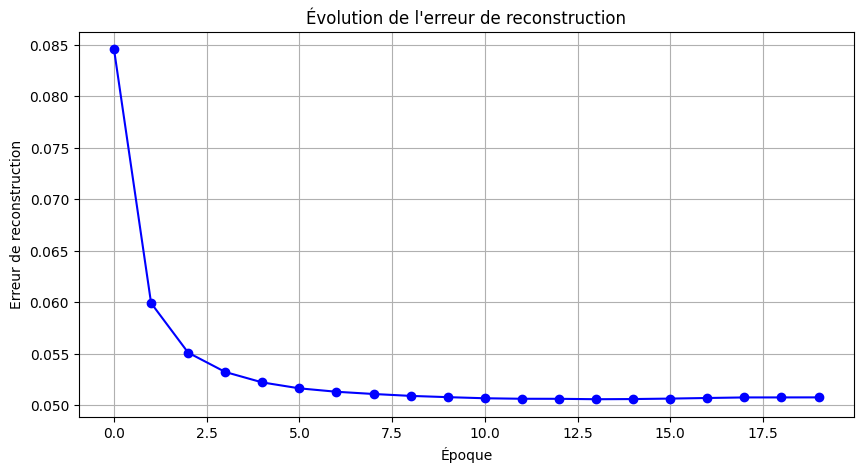

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(errors, marker='o', linestyle='-', color='b')
plt.title("Évolution de l'erreur de reconstruction")
plt.xlabel('Époque')
plt.ylabel('Erreur de reconstruction')
plt.grid(True)
plt.show()

Cela confirme donc la diminution de la loss au fur et à mesure de l'entrainement, ce qui montre que la RBM fonctionne correctement.

Une autre manière d'évaluer la performance de la RBM est de visualiser la reconstruction des images issues des données de test, ce que nous faisons dans le code ci-dessous :

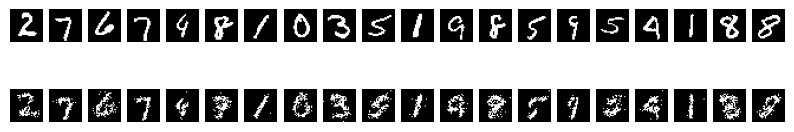

In [31]:
def show_reconstructed_images(model, data, n_samples=20):
    # choix aléatoire des images que l'on va reconstruire
    indices = np.random.choice(len(data), n_samples, replace=False)
    selected_samples = data[indices]

    # obtention des échantillons d'unités cachées à partir de ceux sélectionnés
    _, hidden_samples = model._sample_hidden(selected_samples)
    # reconstruction des images à partir des états cachés et sélection des états binaires reconstruits
    reconstructed_images = model._sample_visible(hidden_samples)[1]

    plt.figure(figsize=(10, 4))
    for i in range(n_samples):
        # affichage de chaque image originale
        plt.subplot(4, n_samples, i + 1)
        plt.imshow(selected_samples[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

        # affichage de l'image reconstruite
        plt.subplot(4, n_samples, i + n_samples + 1)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()

# on applique au dataset x_test
show_reconstructed_images(rbm_simplified, x_test_binarized)

Nous pouvons voir que les images sont globalement bien reconstruites : en effet, certaines sont totalemet reconnaissables et bien identifiées, mais pour certains chiffres, les images contiennent du bruit, montrant que le modèle n'est bien évidemment pas parfait.

Enfin, nous pouvons extraites les 64 composants identifiés par la RBM :

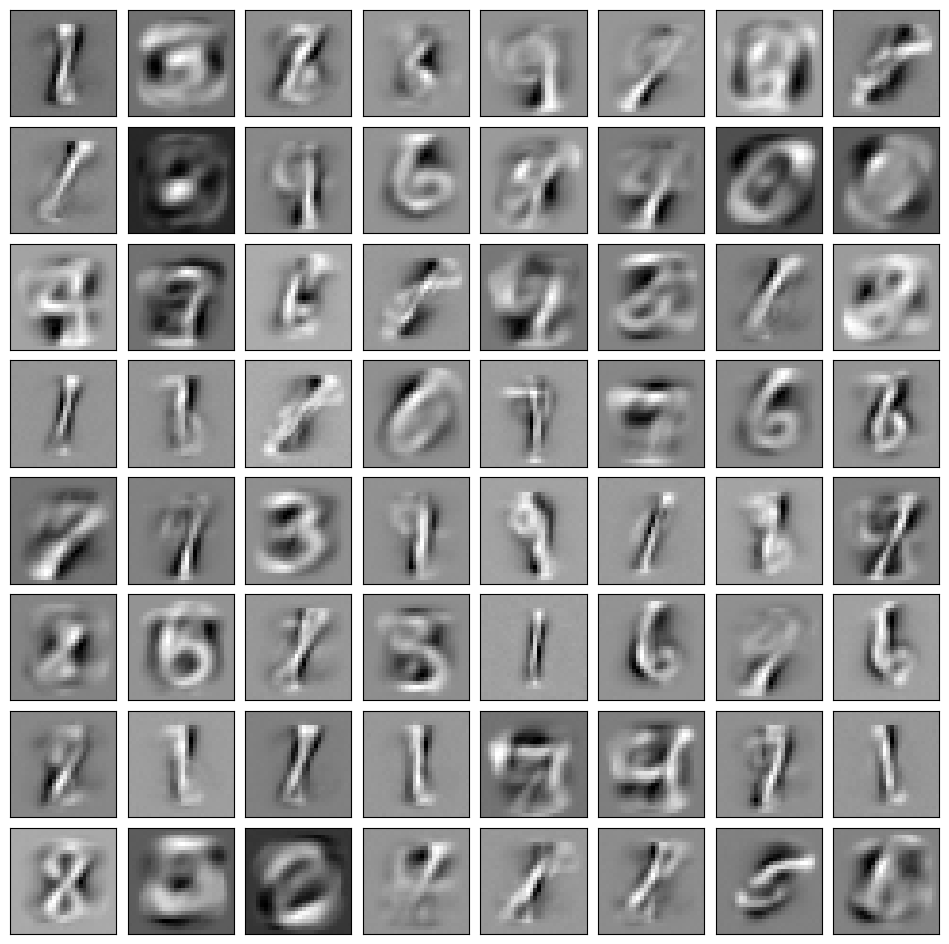

In [32]:
import matplotlib.pyplot as plt

n_components = 64
image_shape = (28, 28)

n_rows = int(n_components ** 0.5)
n_cols = int(np.ceil(n_components / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    if i < n_components:
        # affichage de l'image des poids de la i-ème composante, qu'on redimensionne selon forme de l'image
        ax.imshow(rbm_simplified.weights[:, i].reshape(image_shape), cmap='gray')
    else:
        ax.axis('off')

fig.set_size_inches(n_cols * 1.5, n_rows * 1.5)

plt.show()

Cela montre également la capacité de la RBM a identifié les caractéristiques clés des chiffres dans le dataset MNIST.


Ainsi, les trois méthodes d'évaluation montre que la RBM implémentée de zéro possède de bonne performance, qui pourraît toutefois être améliorée, en, par exemple, optimisant les hyperparamètres, ou augmentant le nombre d'epochs.

Il pourrait être intéressant de comparer nos performances à celle de la classe RBM de la librairie `sklearn`.

## Bonus : comparaison avec RBM de `sklearn`

Nous allons donc utiliser la RBM de `sklearn`, avec les mêmes hyperparamètres, afin de comparer les performances avec notre RBM.

In [33]:
from sklearn.neural_network import BernoulliRBM

rbm_sklearn = BernoulliRBM(n_components=64, learning_rate=0.05, batch_size=87, n_iter=20, verbose=True)

In [34]:
rbm_sklearn.fit(x_train_binarized)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -143.50, time = 5.99s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -124.50, time = 5.47s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -117.21, time = 7.02s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -111.37, time = 5.46s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -108.29, time = 7.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -104.39, time = 5.50s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -101.55, time = 6.96s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -101.78, time = 5.51s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -98.48, time = 6.90s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -99.93, time = 5.49s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -97.40, time = 7.18s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -96.80, time = 5.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -96.44, time = 6.88s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -95.81, time = 5.54s
[BernoulliRBM] Iterat

BernoulliRBM(batch_size=87, learning_rate=0.05, n_components=64, n_iter=20,
             verbose=True)

La RBM de `sklearn` a un temps d'execution moyen de 6.2 secondes, mais ne permet pas d'avoir la valeur de la loss au fur et à mesure des epochs, mais nous pouvons en calculer la moyenne pour l'ensemble de test et d'entraînement, comme ci-dessous :  

In [35]:
from sklearn.metrics import mean_squared_error

X_reconstructed_train = rbm_sklearn.gibbs(x_train_binarized)
reconstruction_error_train = mean_squared_error(x_train_binarized, X_reconstructed_train)

print(f"Erreur de reconstruction pour le train : {reconstruction_error_train}")

from sklearn.metrics import mean_squared_error

X_reconstructed_test = rbm_sklearn.gibbs(x_test_binarized)
reconstruction_error_test = mean_squared_error(x_test_binarized, X_reconstructed_test)

print(f"Erreur de reconstruction pour le test : {reconstruction_error_test}")

Erreur de reconstruction pour le train : 0.07103514030612244
Erreur de reconstruction pour le test : 0.07109591836734694


Comme on peut le voir, l'erreur de reconstruction moyenne est supérieure à celle que nous obtenons avec notre implémentation de RBM, indiquant une potentielle meilleure performance de notre RBM.

On peut également visualiser les reconstructions, de la même manière que précédemment :

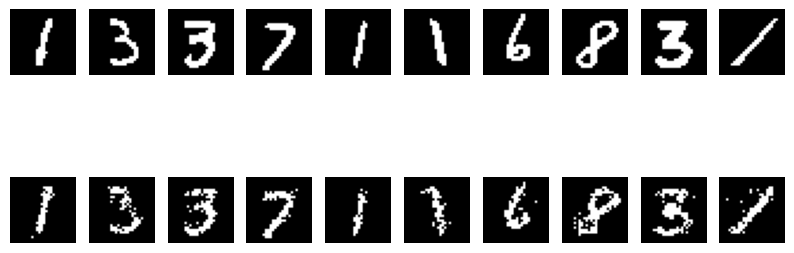

In [44]:
import numpy as np
import matplotlib.pyplot as plt

x_test_reconstructed = rbm_sklearn.gibbs(x_test_binarized) # on utilise la fonction gibbs pour la reconstruction
n_samples = 10
sample_indices = np.random.choice(len(x_test_binarized), n_samples, replace=False)

selected_samples = x_test_binarized[sample_indices]
selected_reconstructed = x_test_reconstructed[sample_indices]

plt.figure(figsize=(10, 4))

for i, index in enumerate(sample_indices):

    plt.subplot(2, n_samples, i + 1)
    plt.imshow(selected_samples[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(selected_reconstructed[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()

On peut voir que la plupart des images ont été bien reconstruites pour la plupart, même si elles contiennent du bruit, ce qui indique une bonne perfance du modèle.

Enfin, on peut extraire les composants identifiés par la RBM de `sklearn` :

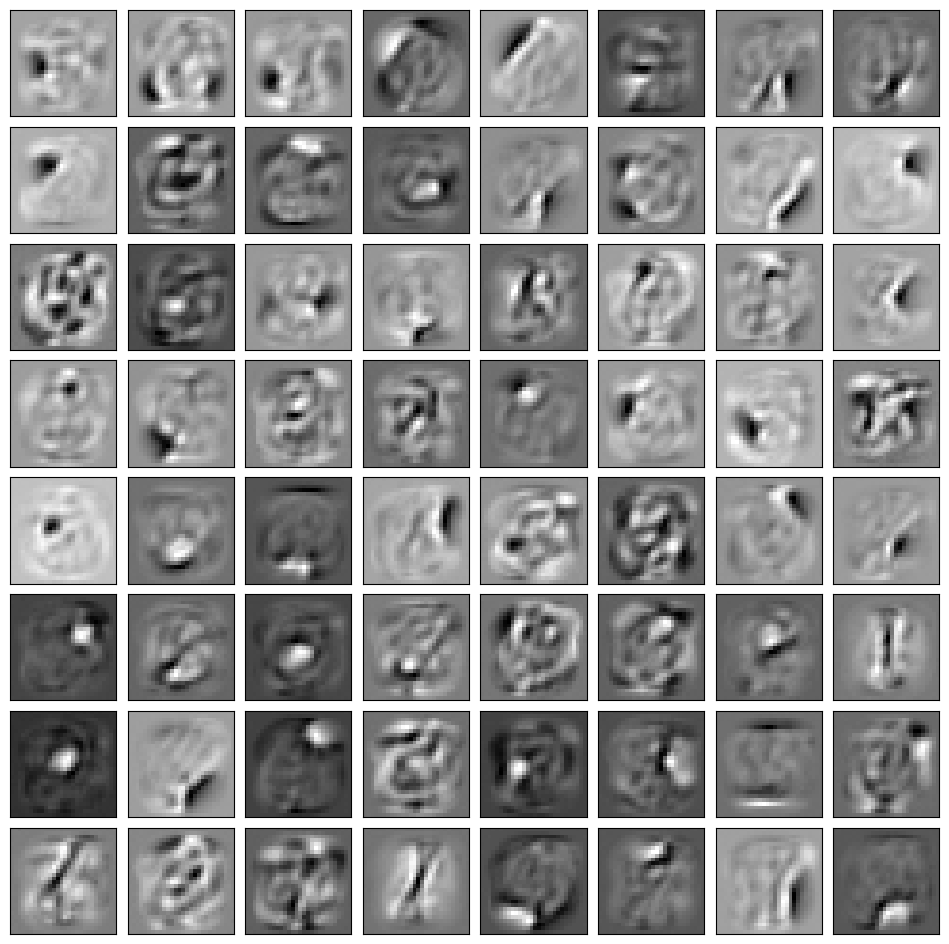

In [43]:
import matplotlib.pyplot as plt

n_components = 64
image_shape = (28, 28)

n_rows = int(n_components ** 0.5)
n_cols = int(np.ceil(n_components / n_rows))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    if i < n_components:
        ax.imshow(rbm_sklearn.components_[i].reshape(image_shape), cmap='gray')
    else:
        ax.axis('off')

fig.set_size_inches(n_cols * 1.5, n_rows * 1.5)

plt.show()


On peut voir que les composants extraits sont plus difficilement identifiables pour la RBM de `sklearn` que celle implémentée de zéro.

Ainsi il semblerait que, même si le temps d'exécution est similaire, la RBM réalisée *from scratch* capture de manière plus efficace les caractéristiques clés des images, mais cela pourrait être du aux hyperparamètres non adaptés à la RBM de `sklearn`.



Pour conclure, ce notebook ainsi que la vidéo associée a permis d'introduire la notion de RBM, et de voir comment est réalisée une implémentation d'une RBM à partir de zéro, avec en bonus, une comparaison avec la librairie `sklearn`.